- recent update: 24.10.29
- update content:
    1. mid-price 생성
    2. significant or insignificant 예측 모델 생성
    3. significant 예측되는 경우에만 significant increase or decrease인지 예측
- target var: mid price return significant change (0 or 1)
- Model: XGBoost(significant or insignificant 예측) + LSTM(significant increase or decrease 예측)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_auc_score
from imblearn.over_sampling import SMOTE
import seaborn as sns
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import precision_score
#from optuna.integration import XGBoostPruningCallback
#import optuna

In [3]:
df = pd.read_csv('/content/drive/MyDrive/df_processed_2024_03_07to10_v2.csv')

In [4]:
df.head()

,false.2,1_min_return,5_min_return,10_min_return,ask_price_1,ask_price_10,ask_price_11,ask_price_12,ask_price_13,ask_price_14,...,RSI25_midprice,return_vol_3_midprice,return_vol_10_midprice,return_vol_25_midprice,orderbook_imbalance,1_min_return_atbest,5_min_return_atbest,10_min_return_atbest,trade_count_for_one_minute,trade_volume_for_one_minute
0,2024-03-07 00:12:51.303000+00:00,0.000924,-0.000962,-0.003147,93620000,93663000,93666000,93668000,93669000,93670000,...,50.000000,0.000003,0.000003,0.000002,-0.206006,0.000534,0.000534,0.000534,277.0,5.726144
1,2024-03-07 00:12:51.503000+00:00,0.000924,-0.000962,-0.003152,93620000,93663000,93666000,93668000,93669000,93670000,...,50.000000,0.000000,0.000003,0.000002,-0.230908,0.000534,0.000534,0.000534,278.0,5.799944
2,2024-03-07 00:12:51.603000+00:00,0.000924,-0.000962,-0.003152,93620000,93663000,93666000,93668000,93669000,93670000,...,50.000000,0.000000,0.000002,0.000002,-0.230723,0.000534,0.000534,0.000534,276.0,5.746356
3,2024-03-07 00:12:51.703000+00:00,0.000395,-0.001491,-0.003681,93620000,93663000,93666000,93668000,93669000,93670000,...,97.115385,0.000305,0.000167,0.000106,-0.227128,0.000534,0.000534,0.000534,276.0,5.747256
4,2024-03-07 00:12:52.003000+00:00,0.000166,-0.001491,-0.003676,93620000,93663000,93666000,93668000,93669000,93670000,...,97.115385,0.000305,0.000167,0.000106,-0.226493,0.000534,0.000534,0.000534,274.0,5.734321


In [5]:
# 시간 타입으로 변경
df['false.2'] = pd.to_datetime(df['false.2'])

# 데이터프레임 리샘플링 - 'timestamp_column'을 타임스탬프 컬럼 이름으로 변경하세요
df.set_index('false.2', inplace=True)  # 타임스탬프를 인덱스로 설정
df = df.resample('1S').max()  # 1초 단위로 묶어서 평균값 계산

# 결과 확인
df.head(20)
print(df.shape)

df.reset_index(inplace=True)

<ipython-input-5-31651f7dabca>:6: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  df = df.resample('1S').max()  # 1초 단위로 묶어서 평균값 계산


(431229, 105)


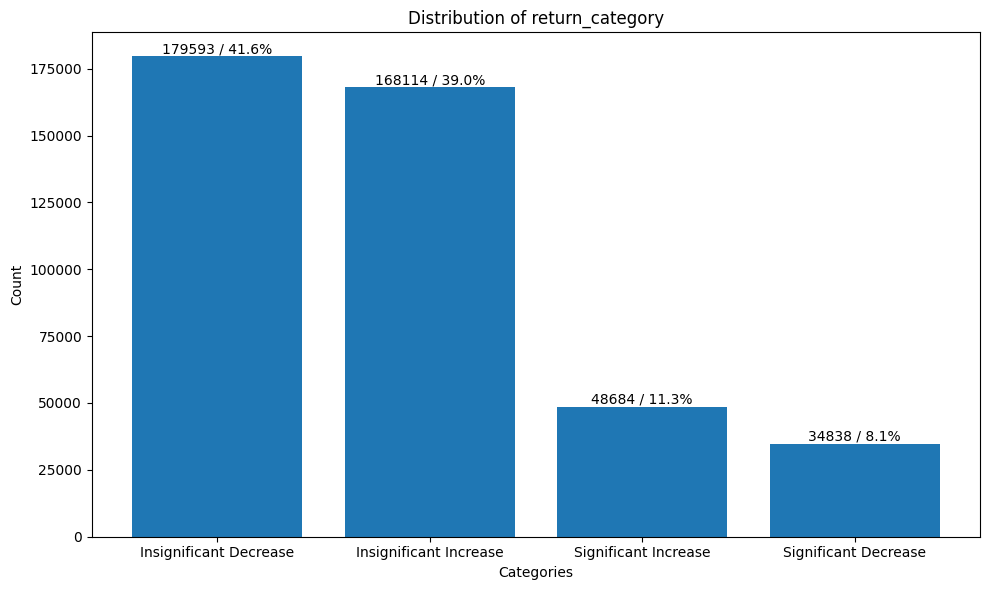

In [6]:
# 범주화 기준
threshold = 0.002

def categorize_return(value):
    if value >= threshold:
        return 'Significant Increase'
    elif value <= -threshold:
        return 'Significant Decrease'
    elif 0 <= value < threshold:
        return 'Insignificant Increase'
    else:
        return 'Insignificant Decrease'

# 범주화된 컬럼 추가
df['return_category'] = df['10_min_return'].apply(categorize_return)

# 카테고리 비율 계산
category_counts = df['return_category'].value_counts(normalize=True)

# return_category 분포 계산
value_counts = df['return_category'].value_counts()
total_count = len(df)
percentages = (value_counts / total_count * 100).round(1)

# 라벨과 값 생성
labels = [f"{cat} ({count} / {percent}%)" for cat, count, percent in zip(value_counts.index, value_counts, percentages)]

# 바 차트 생성 (값 레이블 포함)
plt.figure(figsize=(10, 6))
bars = plt.bar(value_counts.index, value_counts.values)

# 막대 위에 값과 백분율 추가
for bar, count, percent in zip(bars, value_counts, percentages):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             f"{count} / {percent}%", ha='center', va='bottom')

# 차트 꾸미기
plt.title('Distribution of return_category')
plt.ylabel('Count')
plt.xlabel('Categories')
plt.xticks(value_counts.index, value_counts.index)  # 라벨 이름만 표시
plt.tight_layout()
plt.show()


In [7]:
# 라벨을 번호로 매핑
label_mapping = {label: idx for idx, label in enumerate(df['return_category'].unique())}
df['binary_target'] = df['return_category'].map(label_mapping)

# 결과 확인
print("Label mapping:", label_mapping)
print(df['binary_target'].value_counts())


Label mapping: {'Significant Decrease': 0, 'Insignificant Decrease': 1, 'Insignificant Increase': 2, 'Significant Increase': 3}
binary_target
1    179593
2    168114
3     48684
0     34838
Name: count, dtype: int64


In [8]:
print(list(df.columns))

['false.2', '1_min_return', '5_min_return', '10_min_return', 'ask_price_1', 'ask_price_10', 'ask_price_11', 'ask_price_12', 'ask_price_13', 'ask_price_14', 'ask_price_15', 'ask_price_2', 'ask_price_3', 'ask_price_4', 'ask_price_5', 'ask_price_6', 'ask_price_7', 'ask_price_8', 'ask_price_9', 'ask_size_1', 'ask_size_10', 'ask_size_11', 'ask_size_12', 'ask_size_13', 'ask_size_14', 'ask_size_15', 'ask_size_2', 'ask_size_3', 'ask_size_4', 'ask_size_5', 'ask_size_6', 'ask_size_7', 'ask_size_8', 'ask_size_9', 'bid_price_1', 'bid_price_10', 'bid_price_11', 'bid_price_12', 'bid_price_13', 'bid_price_14', 'bid_price_15', 'bid_price_2', 'bid_price_3', 'bid_price_4', 'bid_price_5', 'bid_price_6', 'bid_price_7', 'bid_price_8', 'bid_price_9', 'bid_size_1', 'bid_size_10', 'bid_size_11', 'bid_size_12', 'bid_size_13', 'bid_size_14', 'bid_size_15', 'bid_size_2', 'bid_size_3', 'bid_size_4', 'bid_size_5', 'bid_size_6', 'bid_size_7', 'bid_size_8', 'bid_size_9', 'total_ask_size', 'total_bid_size', 'mid_pric

In [9]:
# NaN 값 개수 확인
print("NaN 값 개수 확인:")
print(df.isna().sum())  # 각 열별 NaN 값 개수 출력

# 전체 데이터프레임에서 NaN 값 총합
print("\n전체 NaN 값 총합:", df.isna().sum().max())

# NaN 값 제거
df = df.dropna()

# 제거 후 결과 확인
print("\nNaN 제거 후 데이터프레임 크기:", df.shape)

NaN 값 개수 확인:
false.2                            0
1_min_return                   13766
5_min_return                   14003
10_min_return                  14301
ask_price_1                    13707
                               ...  
10_min_return_atbest           13766
trade_count_for_one_minute     13766
trade_volume_for_one_minute    13766
return_category                    0
binary_target                      0
Length: 108, dtype: int64

전체 NaN 값 총합: 14301

NaN 제거 후 데이터프레임 크기: (416928, 108)


In [10]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
import numpy as np

# 1. 시계열 데이터 분할 (Train, Validation, Test)
train_size = int(len(df) * 0.7)
valid_size = int(len(df) * 0.15)

train_data = df[:train_size]
valid_data = df[train_size:train_size + valid_size]
test_data = df[train_size + valid_size:]

print(f"Train size: {len(train_data)}, Validation size: {len(valid_data)}, Test size: {len(test_data)}")

# 2. Standard Scaling
scaler = StandardScaler()

drop_cols = ['false.2', '1_min_return', '1_min_return_atbest', '5_min_return', '5_min_return_atbest',
             '10_min_return', '10_min_return_atbest', 'return_category', 'binary_target', 'mid_price_diff',
             'return_vol_3_midprice', 'return_vol_10_midprice', 'return_vol_25_midprice']

# Train 데이터의 Feature를 기준으로 Scaling
train_features = train_data.drop(columns=drop_cols)
valid_features = valid_data.drop(columns=drop_cols)
test_features = test_data.drop(columns=drop_cols)

# Scaling 수행
scaler.fit(train_features)  # Train 데이터만 기준으로 스케일링
X_train_scaled = scaler.transform(train_features)
X_valid_scaled = scaler.transform(valid_features)
X_test_scaled = scaler.transform(test_features)

y_train = train_data['binary_target'].values
y_valid = valid_data['binary_target'].values
y_test = test_data['binary_target'].values

# Sequence 길이 정의
sequence_length = 30
batch_size = 64

# 데이터셋 정의 (Sequence 지원)
class TimeSeriesDatasetWithSequence(Dataset):
    def __init__(self, X, y, sequence_length):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)  # target을 Long 타입으로 설정
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.X) - self.sequence_length + 1

    def __getitem__(self, idx):
        X_seq = self.X[idx:idx + self.sequence_length]  # (sequence_length, feature_dim)
        y_seq = self.y[idx + self.sequence_length - 1]  # 마지막 시점의 y 값
        return X_seq, y_seq

# Train, Validation, Test Dataset 생성
train_dataset = TimeSeriesDatasetWithSequence(X_train_scaled, y_train, sequence_length)
valid_dataset = TimeSeriesDatasetWithSequence(X_valid_scaled, y_valid, sequence_length)
test_dataset = TimeSeriesDatasetWithSequence(X_test_scaled, y_test, sequence_length)

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train Loader Batches: {len(train_loader)}")
print(f"Validation Loader Batches: {len(valid_loader)}")
print(f"Test Loader Batches: {len(test_loader)}")

# def oversample_time_series(dataset):
#     # Sequence 데이터를 X, y로 분리
#     all_X, all_y = [], []
#     for X, y in dataset:
#         all_X.append(X)  # 텐서 형태 유지
#         all_y.append(y.item())

#     all_y = np.array(all_y)

#     # 클래스별 분포 확인
#     class_counts = np.bincount(all_y.astype(int))
#     max_class_count = class_counts.max()
#     print(f"Original class distribution: {class_counts}")

#     # 오버샘플링 수행
#     oversampled_X, oversampled_y = [], []
#     for cls in range(len(class_counts)):
#         cls_indices = np.where(all_y == cls)[0]
#         cls_samples = [all_X[idx] for idx in cls_indices]
#         cls_labels = all_y[cls_indices]

#         # 필요한 샘플 수만큼 복제하여 추가
#         num_to_add = max_class_count - len(cls_indices)
#         if num_to_add > 0:
#             extra_indices = np.random.choice(cls_indices, size=num_to_add, replace=True)
#             oversampled_X.extend(cls_samples)
#             oversampled_X.extend([all_X[idx] for idx in extra_indices])
#             oversampled_y.extend(cls_labels)
#             oversampled_y.extend(all_y[extra_indices])
#         else:
#             oversampled_X.extend(cls_samples)
#             oversampled_y.extend(cls_labels)

#     # 텐서로 변환
#     oversampled_X = torch.stack(oversampled_X)  # (num_samples, sequence_length, feature_dim)
#     oversampled_y = torch.tensor(oversampled_y, dtype=torch.float32)  # (num_samples,)

#     print(f"Oversampled class distribution: {np.bincount(oversampled_y.numpy().astype(int))}")

#     return oversampled_X, oversampled_y

# # Train 데이터 오버샘플링 수행
# oversampled_X_train, oversampled_y_train = oversample_time_series(train_dataset)

# # 오버샘플링된 데이터로 Train Dataset 및 DataLoader 생성
# train_dataset = torch.utils.data.TensorDataset(oversampled_X_train, oversampled_y_train)
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

# # 확인
# for X, y in train_loader:
#     print(f"Input shape: {X.shape}, Target shape: {y.shape}")
#     break


Train size: 291849, Validation size: 62539, Test size: 62540
Train Loader Batches: 4560
Validation Loader Batches: 977
Test Loader Batches: 977


cuda


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/100], Train Loss: 1.1612, Valid Loss: 1.2153, Accuracy: 0.3804
Epoch [2/100], Train Loss: 1.1608, Valid Loss: 1.1985, Accuracy: 0.3772
Epoch [3/100], Train Loss: 1.1511, Valid Loss: 1.2016, Accuracy: 0.3828
Epoch [4/100], Train Loss: 1.1404, Valid Loss: 1.2036, Accuracy: 0.3929
Epoch [5/100], Train Loss: 1.1391, Valid Loss: 1.2069, Accuracy: 0.3967
Epoch [6/100], Train Loss: 1.1322, Valid Loss: 1.2087, Accuracy: 0.4019
Epoch [7/100], Train Loss: 1.1279, Valid Loss: 1.2177, Accuracy: 0.4076
Epoch [8/100], Train Loss: 1.1260, Valid Loss: 1.2208, Accuracy: 0.4091
Epoch [9/100], Train Loss: 1.1252, Valid Loss: 1.1839, Accuracy: 0.4147
Epoch [10/100], Train Loss: 1.1155, Valid Loss: 1.1827, Accuracy: 0.4147
Epoch [11/100], Train Loss: 1.1122, Valid Loss: 1.1851, Accuracy: 0.4143
Epoch [12/100], Train Loss: 1.1102, Valid Loss: 1.1874, Accuracy: 0.4126
Epoch [13/100], Train Loss: 1.1082, Valid Loss: 1.1883, Accuracy: 0.4113
Epoch [14/100], Train Loss: 1.1060, Valid Loss: 1.1898, Accu

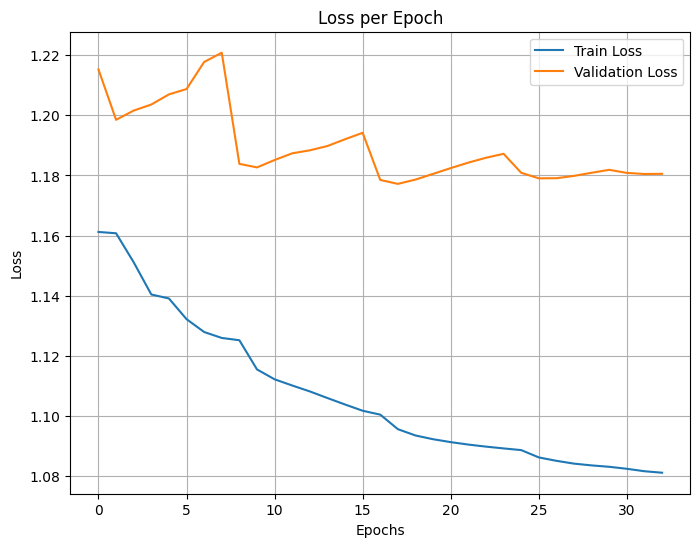

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

# Multi-class Classification Model 정의
class MultiClassLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout_rate, num_classes):
        super(MultiClassLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers,
                            batch_first=True, dropout=dropout_rate)
        self.fc = nn.Linear(hidden_dim, num_classes)  # Multi-class classification

    def forward(self, x):
        _, (hidden, _) = self.lstm(x)
        return self.fc(hidden[-1])  # Last hidden state

# Hyperparameters
hyperparams = {
    "input_dim": X_train_scaled.shape[1],  # Number of features
    "hidden_dim": 32,                    # LSTM hidden dimension
    "num_layers": 1,                      # Number of LSTM layers
    "dropout_rate": 0.5,                  # Dropout rate
    "batch_size": 64,                     # Batch size
    "epochs": 100,                         # Number of training epochs
    "learning_rate": 1e-4,                # Lower initial learning rate
    "weight_decay": 1e-5,                 # Weight decay for regularization
    "gradient_clipping": 1.0,             # Max norm for gradient clipping
    "num_classes": 4                      # Number of output classes
}

# Model 초기화
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = MultiClassLSTM(
    input_dim=hyperparams["input_dim"],
    hidden_dim=hyperparams["hidden_dim"],
    num_layers=hyperparams["num_layers"],
    dropout_rate=hyperparams["dropout_rate"],
    num_classes=hyperparams["num_classes"]
).to(device)

# Weights initialization function
def initialize_weights(m):
    if isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if "weight_ih" in name:  # Input to hidden weights
                nn.init.xavier_uniform_(param.data)
            elif "weight_hh" in name:  # Hidden to hidden weights
                nn.init.orthogonal_(param.data)
            elif "bias" in name:  # Bias terms
                nn.init.constant_(param.data, 0.0)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight.data)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0.0)

# Apply weights initialization
model.apply(initialize_weights)

# Loss function 및 Optimizer
criterion = nn.CrossEntropyLoss()  # Multi-class classification
optimizer = optim.Adam(model.parameters(), lr=hyperparams["learning_rate"], weight_decay=hyperparams["weight_decay"])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, verbose=True)

# Training Loop
def train_model(model, train_loader, valid_loader, hyperparams):
    train_losses, valid_losses = [], []
    best_valid_loss = float("inf")
    patience_counter = 0

    for epoch in range(hyperparams["epochs"]):
        # Training Phase
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            y_pred = model(X_batch)  # Output logits
            loss = criterion(y_pred, y_batch)  # No need for softmax
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=hyperparams["gradient_clipping"])
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Validation Phase
        model.eval()
        valid_loss = 0
        all_preds, all_targets = [], []
        with torch.no_grad():
            for X_batch, y_batch in valid_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_pred = model(X_batch)
                loss = criterion(y_pred, y_batch)
                valid_loss += loss.item()
                all_preds.extend(torch.argmax(y_pred, dim=1).cpu().numpy())  # Multi-class predictions
                all_targets.extend(y_batch.cpu().numpy())

        valid_loss /= len(valid_loader)
        valid_losses.append(valid_loss)

        # Scheduler step
        scheduler.step(valid_loss)

        # Early stopping
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            patience_counter = 0
            torch.save(model.state_dict(), "best_multiclass_model_2.pth")
        else:
            patience_counter += 1
            if patience_counter >= 15:  # Early stopping patience
                print(f"Early stopping at epoch {epoch + 1}")
                break

        # Performance metrics
        accuracy = accuracy_score(all_targets, all_preds)
        print(f"Epoch [{epoch+1}/{hyperparams['epochs']}], Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}, Accuracy: {accuracy:.4f}")

    return train_losses, valid_losses

# Training 시작
train_losses, valid_losses = train_model(model, train_loader, valid_loader, hyperparams)

# Training 및 Validation Loss 시각화
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label="Train Loss")
plt.plot(valid_losses, label="Validation Loss")
plt.title("Loss per Epoch")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()


<ipython-input-12-2517d815855a>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_multiclass_model_2.pth"))  # 모델 로드



Test Performance:
              precision    recall  f1-score   support

           0     0.0989    0.0033    0.0063      7972
           1     0.2854    0.0207    0.0386     20119
           2     0.3576    0.9698    0.5226     22320
           3     0.0909    0.0020    0.0039     12100

    accuracy                         0.3537     62511
   macro avg     0.2082    0.2489    0.1429     62511
weighted avg     0.2498    0.3537    0.2006     62511



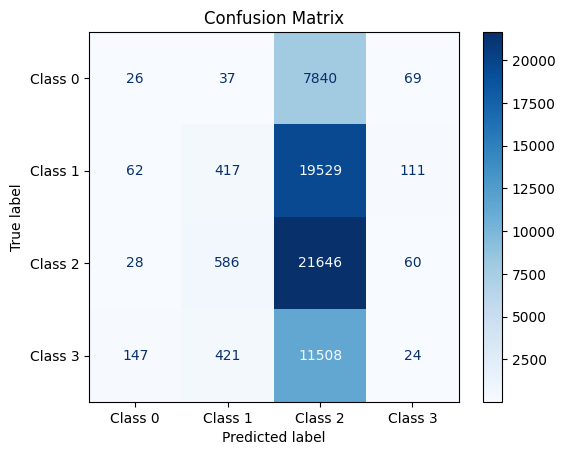

Class0: Significant Decrease
 Class1: Insignificant Decrease
 Class2: Insignificant Increase
 Class3: Significant Increase



In [12]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import torch

# Testing
def test_model_with_sklearn(model, test_loader):
    model.load_state_dict(torch.load("best_multiclass_model_2.pth"))  # 모델 로드
    model.eval()

    all_preds, all_targets = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device).long()  # Ensure target is Long
            y_pred = model(X_batch)  # (batch_size, num_classes)
            y_pred = torch.argmax(y_pred, dim=1)  # 클래스 레이블로 변환
            all_preds.extend(y_pred.cpu().numpy())  # Append predictions
            all_targets.extend(y_batch.cpu().numpy())  # Append true labels

    # NumPy로 변환
    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)

    # 성능 평가
    print("\nTest Performance:")
    print(classification_report(all_targets, all_preds, digits=4))

    # Confusion Matrix 계산 및 시각화
    cm = confusion_matrix(all_targets, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"Class {i}" for i in range(hyperparams["num_classes"])])
    disp.plot(cmap="Blues", values_format="d")
    plt.title("Confusion Matrix")
    plt.show()

    print("Class0: Significant Decrease\n",
          'Class1: Insignificant Decrease\n',
          'Class2: Insignificant Increase\n',
          'Class3: Significant Increase\n')

# Test model
test_model_with_sklearn(model, test_loader)


### 실제 데이터에 적용
- insignificant increase, decrease도 적용

- Precision (정밀도):

정밀도는 모델이 해당 클래스로 예측한 값 중 실제로 맞은 비율입니다.
예를 들어, "Significant increase" 클래스에 대해 모델이 98%의 정밀도를 보였다는 것은, 모델이 이 클래스로 예측한 값 중 98%가 실제로 맞았다는 의미입니다.
하지만 "Significant decrease" 클래스는 데이터에 등장하지 않아서 정밀도가 0.00으로 표시되었습니다.

- Recall (재현율):

재현율은 실제로 해당 클래스에 속한 데이터 중에서 모델이 올바르게 예측한 비율입니다.
예를 들어, "Insignificant increase" 클래스에 대한 재현율이 0.92라는 것은, 실제로 "Insignificant increase"에 속한 데이터 중 92%를 모델이 정확히 맞췄다는 의미입니다.
"Significant increase" 클래스의 재현율이 0.01이라는 것은, 이 클래스에 속한 실제 데이터 중 1%만 모델이 맞췄다는 의미입니다.

- F1-score:

F1 스코어는 정밀도와 재현율의 조화평균으로, 두 지표를 종합적으로 평가하는 지표입니다. 정밀도와 재현율 사이의 균형을 중요시할 때 유용합니다.
예를 들어, "Insignificant increase" 클래스의 F1 스코어가 0.84라는 것은, 정밀도와 재현율이 적절히 균형을 이뤘음을 의미합니다.

- Support:

Support는 각 클래스에 실제로 속한 데이터의 개수입니다.
예를 들어, "Insignificant increase" 클래스는 241,234개의 데이터 포인트를 가지고 있다는 것을 의미합니다.

- Micro avg (마이크로 평균):

마이크로 평균은 전체 데이터에서의 정밀도, 재현율, F1 스코어를 계산합니다. 이는 각 클래스의 데이터 개수를 고려하지 않고, 전체 데이터를 한 번에 평가하는 방식입니다.
마이크로 평균 77%는 모든 클래스의 데이터를 합쳐서 모델이 77%의 정확도를 보였음을 의미합니다.

- Macro avg (매크로 평균):

매크로 평균은 각 클래스의 정밀도, 재현율, F1 스코어의 평균을 단순히 계산한 것입니다. 이는 클래스별 데이터 비율을 고려하지 않기 때문에, 클래스 간 불균형이 있는 경우 잘못된 평가가 나올 수 있습니다.
예를 들어, "Significant decrease" 클래스처럼 데이터가 없는 클래스는 성능이 0으로 평가되며, 이러한 클래스들도 평균에 포함되기 때문에 성능이 낮아집니다.

- Weighted avg (가중 평균):

가중 평균은 각 클래스의 정밀도, 재현율, F1 스코어를 해당 클래스의 데이터 개수에 비례하여 평균을 계산한 것입니다. 즉, 클래스의 데이터가 많을수록 해당 클래스의 성능이 평균에 더 큰 영향을 줍니다.
Weighted 평균 77%는 실제 데이터 비율에 따라 가중치를 부여하여 계산한 성능입니다. 이 값은 전체적으로 모델이 77%의 정확도를 가지고 있음을 보여줍니다.